In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import gc
from IPython.core.display import display, HTML, display_pretty
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
from imblearn.datasets import make_imbalance
os.chdir('/home/sambeet/data/dsg/')
import fastFM as fm
import time
from fastFM import als
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

In [2]:
trade = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
trade['BuySell'] = trade['BuySell'].astype('category')
trade['TradeStatus'] = trade['TradeStatus'].astype('category')
trade['CustomerInterest'] = trade['CustomerInterest'].astype('bool')
trade['year'] = trade.TradeDateKey.dt.year
trade['month'] = trade.TradeDateKey.dt.month
trade['weekofyear'] = trade.TradeDateKey.dt.weekofyear
test = trade[['CustomerIdx','IsinIdx','BuySell']].drop_duplicates()
trade.drop(['TradeDateKey','NotionalEUR','Price','TradeStatus','month'],axis=1,inplace=True)
trade.head()

,CustomerIdx,IsinIdx,BuySell,CustomerInterest,year,weekofyear
0,2789,8478,Sell,True,2016,49
1,2574,14562,Buy,True,2017,13
2,2574,4747,Buy,True,2017,16
3,2574,9885,Sell,True,2017,10
4,2574,8885,Buy,True,2016,46


In [12]:
trade = trade[trade.CustomerInterest == True]

In [4]:
synth_data = pd.DataFrame()
yearlist = list(np.unique(trade.year))
weekofyearlist = list(np.unique(trade.weekofyear))
start = time.time()
for year in yearlist:
    print year
    for weekofyear in weekofyearlist:
        if year == 2017 and weekofyear == 53:
            continue
        elif year == 2018 and weekofyear >= 17:
            continue
        else:
            temp = test.sample(n=125000).copy()
            temp['year'] = year
            temp['weekofyear'] = weekofyear
            temp['CustomerInterest'] = False
            temp = pd.concat([trade[(trade.year == )]
            synth_data = pd.concat([synth_data,temp],axis=0)
end = time.time()
print (end - start)/60,'minutes'

2016


/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



2017
2018
1.4540100654 minutes


In [5]:
trade.shape

(19140805, 6)

In [6]:
trade = trade[~((trade.year == 2018) & (trade.weekofyear >= 16))].reset_index(drop=True)
del temp,test
gc.collect()
trade.shape

(19012426, 6)

In [7]:
trade = trade.groupby(['CustomerIdx','IsinIdx','BuySell','year','weekofyear'])['CustomerInterest'].sum().reset_index()
trade['CustomerInterest'] = trade.CustomerInterest >= 1
trade.shape

(18206353, 6)

In [8]:
encoder_bs = LabelEncoder()
encoder_bs.fit(trade['BuySell'].astype(str))
trade['BuySell'] = encoder_bs.transform(trade['BuySell'].astype(str))
trade.CustomerInterest.mean()

0.0964191455586959

In [9]:
#def one_hot_encode(data,categorical_columns):
#    data = pd.get_dummies(data,columns=categorical_columns,sparse=False,dtype=np.int8)
#    return data    
customer = pd.read_csv('Customer.csv')
customer = customer.rename({'Region':'CustomerRegion'},axis=1)
categorical_columns = ['Sector','Subsector','CustomerRegion','Country']
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
    print 'Transforming {}...'.format(col)
    encoder = LabelEncoder()
    encoder.fit(customer[col].astype(str))
    customer[col] = encoder.transform(customer[col].astype(str))
#customer = one_hot_encode(customer,categorical_columns)
bond = pd.read_csv('Isin.csv',parse_dates=['ActualMaturityDateKey', 'IssueDateKey'])
bond = bond.rename({'Region':'BondRegion'},axis=1)
categorical_columns = ['Seniority','Currency','ActivityGroup','BondRegion','Activity',
       'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue','CouponType']
for col in categorical_columns:
    bond[col] = bond[col].astype('category')
    print 'Transforming {}...'.format(col)
    encoder = LabelEncoder()
    encoder.fit(bond[col].astype(str))
    bond[col] = encoder.transform(bond[col].astype(str))
#bond = one_hot_encode(bond,categorical_columns)

Transforming Sector...
Transforming Subsector...
Transforming CustomerRegion...
Transforming Country...
Transforming Seniority...
Transforming Currency...
Transforming ActivityGroup...
Transforming BondRegion...
Transforming Activity...
Transforming RiskCaptain...
Transforming Owner...
Transforming CompositeRating...
Transforming IndustrySector...
Transforming IndustrySubgroup...
Transforming MarketIssue...
Transforming CouponType...


In [10]:
trade = trade.merge(customer,on=['CustomerIdx'],how='left')
trade = trade.merge(bond,on=['IsinIdx'],how='left')
gc.collect()

168

In [13]:
trade.head()

,CustomerIdx,IsinIdx,BuySell,CustomerInterest,year,weekofyear
0,2789,8478,Sell,True,2016,49
1,2574,14562,Buy,True,2017,13
2,2574,4747,Buy,True,2017,16
3,2574,9885,Sell,True,2017,10
4,2574,8885,Buy,True,2016,46


In [13]:
trade['MaturityPeriod'] = ((trade['ActualMaturityDateKey'] - trade['IssueDateKey'])/365.).dt.days
trade['IssuedAmount'] = np.log1p(trade.IssuedAmount/1000000)
trade.drop(['ActualMaturityDateKey','IssueDateKey'],axis=1,inplace=True)
trade.head()

,CustomerIdx,IsinIdx,BuySell,year,weekofyear,CustomerInterest,Sector,Subsector,CustomerRegion,Country,...,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,MaturityPeriod
0,0,16471,0,2016,1,False,0,24,1,34,...,2,1,0,11,7,247,5,6.311735,0,5
1,0,16471,0,2016,37,False,0,24,1,34,...,2,1,0,11,7,247,5,6.311735,0,5
2,0,16471,0,2016,39,False,0,24,1,34,...,2,1,0,11,7,247,5,6.311735,0,5
3,0,16471,0,2017,20,True,0,24,1,34,...,2,1,0,11,7,247,5,6.311735,0,5
4,0,16471,0,2017,52,False,0,24,1,34,...,2,1,0,11,7,247,5,6.311735,0,5


In [14]:
categorical_holdings = ['CustomerIdx','IsinIdx','BuySell','year','weekofyear','Sector','Subsector','CustomerRegion',
                        'Country','TickerIdx','Seniority','Currency','ActivityGroup','BondRegion','Activity',
                        'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue',
                        'CouponType']
predictors_holdings = list(trade.columns)
predictors_holdings.remove('CustomerInterest')
target_holdings = 'CustomerInterest'
float_type = ['IssuedAmount']
for col in predictors_holdings:
    if col in float_type:
        trade[col] = pd.to_numeric(trade[col],downcast='float')
    else:
        trade[col] = pd.to_numeric(trade[col],downcast='integer')
trade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18206353 entries, 0 to 18206352
Data columns (total 25 columns):
CustomerIdx         int16
IsinIdx             int16
BuySell             int8
year                int16
weekofyear          int8
CustomerInterest    bool
Sector              int8
Subsector           int8
CustomerRegion      int8
Country             int8
TickerIdx           int16
Seniority           int8
Currency            int8
ActivityGroup       int8
BondRegion          int8
Activity            int8
RiskCaptain         int8
Owner               int8
CompositeRating     int8
IndustrySector      int8
IndustrySubgroup    int16
MarketIssue         int8
IssuedAmount        float32
CouponType          int8
MaturityPeriod      int16
dtypes: bool(1), float32(1), int16(6), int8(17)
memory usage: 729.2 MB


In [ ]:
for i,col in zip(range(1,len(predictors_holdings)+1),list(predictors_holdings)):
    print col
    if col in categorical_holdings:
        encoder = OneHotEncoder(sparse=True,dtype=np.int8)
        encoder.fit(pd.DataFrame(trade[col]))
        if i == 1:
            csr_mat = encoder.transform(pd.DataFrame(trade[col]))
        else:
            temp = encoder.transform(pd.DataFrame(trade[col]))
            csr_mat = sparse.hstack([csr_mat,temp],format='csr')

CustomerIdx
IsinIdx
BuySell
year
weekofyear
Sector
Subsector
CustomerRegion
Country
TickerIdx
Seniority
Currency
ActivityGroup
BondRegion
Activity
RiskCaptain
Owner
CompositeRating
IndustrySector


In [ ]:
test = pd.read_csv('Challenge_20180423.csv',parse_dates=['DateKey'])
test = test.rename({'DateKey':'TradeDateKey'},axis=1)
test['BuySell'] = test['BuySell'].astype('category')
test['TradeDateKey'] = '20180423'
test['TradeDateKey'] = pd.to_datetime(test.TradeDateKey)
test['year'] = test.TradeDateKey.dt.year
test['month'] = test.TradeDateKey.dt.month
test['weekofyear'] = test.TradeDateKey.dt.weekofyear
test['BuySell'] = encoder_bs.transform(test['BuySell'].astype(str))
test = test.merge(customer,on=['CustomerIdx'],how='left')
test = test.merge(bond,on=['IsinIdx'],how='left')
test['MaturityPeriod'] = ((test['ActualMaturityDateKey'] - test['IssueDateKey'])/365.).dt.days
test['IssuedAmount'] = np.log1p(test.IssuedAmount/1000000)
test.drop(['ActualMaturityDateKey','IssueDateKey'],axis=1,inplace=True)
#test['CustomerInterest'] = z.predict_proba(test_pred)
#test[['PredictionIdx','CustomerInterest']].to_csv('sub_sam_fm_holdings1_3.csv',index=False)

In [11]:
trade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18205358 entries, 0 to 18205357
Data columns (total 25 columns):
CustomerIdx         int64
IsinIdx             int64
BuySell             int64
year                int64
weekofyear          int64
CustomerInterest    bool
Sector              int64
Subsector           int64
CustomerRegion      int64
Country             int64
TickerIdx           int64
Seniority           int64
Currency            int64
ActivityGroup       int64
BondRegion          int64
Activity            int64
RiskCaptain         int64
Owner               int64
CompositeRating     int64
IndustrySector      int64
IndustrySubgroup    int64
MarketIssue         int64
IssuedAmount        float64
CouponType          int64
MaturityPeriod      int64
dtypes: bool(1), float64(1), int64(23)
memory usage: 3.4 GB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18205358 entries, 0 to 18205357
Data columns (total 25 columns):
CustomerIdx         int16
IsinIdx             int16
BuySell             int8
year                int16
weekofyear          int8
CustomerInterest    bool
Sector              int8
Subsector           int8
CustomerRegion      int8
Country             int8
TickerIdx           int16
Seniority           int8
Currency            int8
ActivityGroup       int8
BondRegion          int8
Activity            int8
RiskCaptain         int8
Owner               int8
CompositeRating     int8
IndustrySector      int8
IndustrySubgroup    int16
MarketIssue         int8
IssuedAmount        float32
CouponType          int8
MaturityPeriod      int16
dtypes: bool(1), float32(1), int16(6), int8(17)
memory usage: 729.2 MB


In [13]:
print(predictors_holdings,len(predictors_holdings),categorical_holdings,len(categorical_holdings),trade.shape[0])

(['CustomerIdx', 'IsinIdx', 'BuySell', 'year', 'weekofyear', 'Sector', 'Subsector', 'CustomerRegion', 'Country', 'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'IssuedAmount', 'CouponType', 'MaturityPeriod'], 24, ['CustomerIdx', 'IsinIdx', 'BuySell', 'year', 'weekofyear', 'Sector', 'Subsector', 'CustomerRegion', 'Country', 'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType'], 22, 18205358)


In [14]:
one_hot_encoded_training_predictors = pd.get_dummies(trade[predictors_holdings],columns=categorical_holdings,sparse=True,dtype=np.int8)

In [15]:
import scipy.sparse as sp
one_hot_encoded_training_predictors = one_hot_encoded_training_predictors.to_sparse()

In [16]:
one_hot_encoded_training_predictors = one_hot_encoded_training_predictors.to_coo()

In [17]:
one_hot_encoded_training_predictors = one_hot_encoded_training_predictors.tocsr()

categorical_indices = np.array([True if col in categorical_holdings else False for col in predictors_holdings])
encoder = OneHotEncoder(categorical_features=categorical_indices,dtype=np.int8,sparse=True)
encoder.fit(trade[predictors_holdings])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_encoded_training_predictors, trade[target_holdings])
y_train = y_train.astype(int).values
y_test = y_test.astype(int).values
y_train[y_train == 0] = -1
#X_train = encoder.transform(X_train)
#X_test = encoder.transform(X_test)

In [ ]:
y_train

In [ ]:
n_iter = 50
step_size = 1
start = time.time()
auc_train = []
auc_test = []
z = als.FMClassification(n_iter=0, l2_reg_w=0.1, l2_reg_V=0.1, rank=4)
z.fit(X_train, y_train)
for i in range(n_iter):
    print 'Training Iteration #',i+1
    z.fit(X_train, y_train, n_more_iter=step_size)
    train_auc = roc_auc_score(y_train,z.predict_proba(X_train))
    test_auc = roc_auc_score(y_test,z.predict_proba(X_test))
    auc_train.append(train_auc)
    auc_test.append(test_auc)
    print 'Train AUC:',train_auc,'Test AUC:',test_auc
end = time.time()
print (end - start)/60, ' minutes'

In [32]:
z.n_iter

0

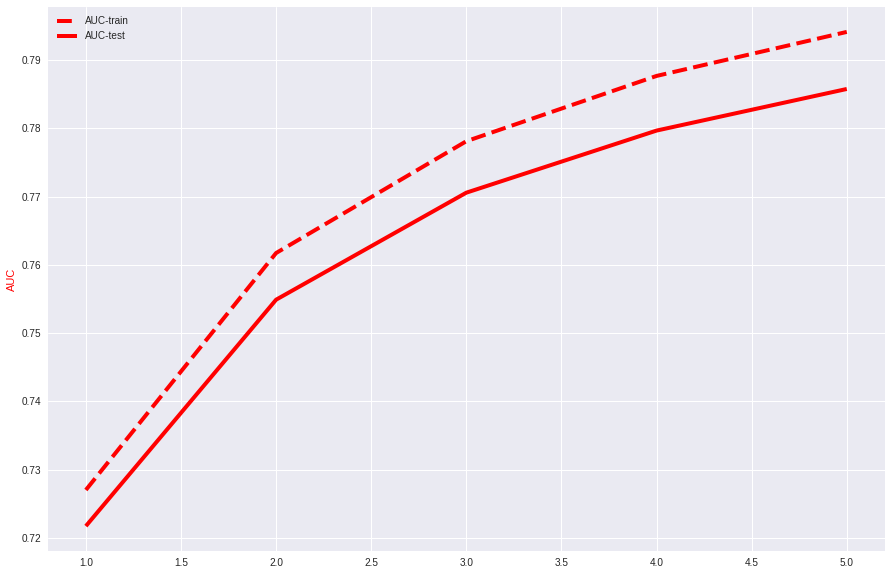

In [28]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=1, figsize=(15, 10))
x = np.arange(1, n_iter+1) * step_size
with plt.style.context('fivethirtyeight'):
    axes.plot(x, auc_train, label='AUC-train', color='r', ls="--")
    axes.plot(x, auc_test, label='AUC-test', color='r')
axes.set_ylabel('AUC', color='r')
axes.legend()

encoder = OneHotEncoder().fit(trade[predictors_holdings])
kf = KFold(n_splits=5,shuffle=True,random_state=37)
kf.get_n_splits(trade)
for train_index, test_index in kf.split(trade):
    X_train = trade.loc[train_index,predictors_holdings]
    X_test = trade.loc[test_index,predictors_holdings]
    y_train = trade.loc[train_index,target_holdings]
    y_test = trade.loc[test_index,target_holdings]
    y_train = y_train.astype(int).values.squeeze()
    y_test = y_test.astype(int).values.squeeze()
    y_train[y_train == 0] = -1
    X_train = encoder.transform(X_train)
    X_test = encoder.transform(X_test)
    print 'Starting training on new fold!'
    z = als.FMClassification(l2_reg_w=0.1, l2_reg_V=0.1, rank=4,n_iter=25)
    z.fit(X_train,y_train)
    y_pred_train = z.predict_proba(X_train)
    y_pred_test = z.predict_proba(X_test)
    y_train[y_train == -1] = 0
    print 'Train AUC: ',roc_auc_score(y_train,y_pred_train)
    print 'Test AUC: ',roc_auc_score(y_test,y_pred_test)

In [13]:
test = pd.read_csv('Challenge_20180423.csv',parse_dates=['DateKey'])
test = test.rename({'DateKey':'TradeDateKey'},axis=1)
test['BuySell'] = test['BuySell'].astype('category')
test['TradeDateKey'] = '20180423'
test['TradeDateKey'] = pd.to_datetime(test.TradeDateKey)
test['year'] = test.TradeDateKey.dt.year
test['month'] = test.TradeDateKey.dt.month
test['weekofyear'] = test.TradeDateKey.dt.weekofyear
test['BuySell'] = encoder_bs.transform(test['BuySell'].astype(str))
test_local = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_local['weekofyear'] = 16
#test_local = test_local.merge(customer,on=['CustomerIdx'],how='left')
#test_local = test_local.merge(bond,on=['IsinIdx'],how='left')
filtered = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
filtered['BuySell'] = filtered['BuySell'].astype('category')
filtered['TradeStatus'] = filtered['TradeStatus'].astype('category')
filtered['CustomerInterest'] = filtered['CustomerInterest'].astype('bool')
filtered['year'] = filtered.TradeDateKey.dt.year
filtered['month'] = filtered.TradeDateKey.dt.month
filtered['weekofyear'] = filtered.TradeDateKey.dt.weekofyear
filtered['BuySell'] = encoder_bs.transform(filtered['BuySell'].astype(str))
test_local = test_local.merge(filtered[['CustomerIdx','IsinIdx','BuySell','year','weekofyear','CustomerInterest']],on=['CustomerIdx','IsinIdx','BuySell','year','weekofyear'],how='left')
test_local['CustomerInterest'][test_local.CustomerInterest.isnull()] = False
del filtered
test_local.head()
y_true = test_local.CustomerInterest.astype(int).values
test_local = encoder.transform(test_local[predictors_holdings])
y_scores = z.predict_proba(test_local)
roc_auc_score(y_true, y_scores)

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.5621202132980729

In [14]:
test = pd.read_csv('Challenge_20180423.csv',parse_dates=['DateKey'])
test = test.rename({'DateKey':'TradeDateKey'},axis=1)
test['BuySell'] = test['BuySell'].astype('category')
test['TradeDateKey'] = '20180423'
test['TradeDateKey'] = pd.to_datetime(test.TradeDateKey)
test['year'] = test.TradeDateKey.dt.year
test['month'] = test.TradeDateKey.dt.month
test['weekofyear'] = test.TradeDateKey.dt.weekofyear
test['BuySell'] = encoder_bs.transform(test['BuySell'].astype(str))
test_pred = encoder.transform(test[predictors_holdings])
test['CustomerInterest'] = z.predict_proba(test_pred)
test[['PredictionIdx','CustomerInterest']].to_csv('sub_sam_fm_holdings1_3.csv',index=False)